In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
def dice(num):
    '''Generates num number of dice rolls'''
    
    return list(np.random.randint(1,7,size=num))

In [ ]:
class territory:
    """A territory within Risk"""
    
    def __init__(self, name, continent, index):
        self.name = name
        self.continent = continent
        self.index = index
        
        self.owner = None
        self.num_units = 0
        return None
        
    def assign_owner(self, owner, num_units):
        self.owner = owner
        self.num_units = num_units
        return None
    
    def change_units(self, unit_addition):
        self.num_units += unit_addition
        return self.num_units

In [ ]:
class player:
    """A player. This is the base class for the opponents and the agent."""
    
    def __init__(self): #Add these later if necessary: num_units=0, num_territories=0, continents_held=None):
        # Initialise all properties
        self.num_units = 0
        self.units_in_hand = 0
        self.num_territories = 0
        self.continents = np.array([0, 0, 0])
        self.owned_territories = []
        return None
    
    def change_units(self, unit_addition):
        """Alter number of units"""
        self.num_units += unit_addition
        return self.num_units
    
    def pick_reinforcement_territory(self):
        
        return np.random.choice(self.owned_territories)
    
    def add_reinf_to_hand(self):
        
        self.units_in_hand += max(np.floor(self.num_territories/3 + sum(self.continents * np.array([7,3,2]))),3) 
        
        return max(np.floor(self.num_territories/3 + sum(self.continents * np.array([7,3,2]))),3)
        
    
    def add_territory(self, territory_index):
        self.num_territories +=1
        self.owned_territories.append(territory_index)
        self.check_continents()
        return self.num_territories, self.owned_territories
    
    def remove_territory(self,territory_index):
        self.num_territories += -1
        self.owned_territories.remove(territory_index)
        self.check_continents()
        return self.num_territories, self.owned_territories
    
    def check_continents(self):
        
        # check if any continents have been made
        
        if set([0,1,2,3,4,5,6,7,8,9,10,11]).issubset(set(self.owned_territories)):
            self.continents[0] = 1
        else:
            self.continents[0] = 0
        if set([12,13,14,15,16,17]).issubset(set(self.owned_territories)):
            self.continents[1] = 1
        else:
            self.continents[1] = 0
        if set([18,19,20,21]).issubset(set(self.owned_territories)):
            self.continents[2] = 1
        else:
            self.continents[2] = 0

In [ ]:
class world_map:
    """The details of the Risk game board in it's current state"""
    
    def __init__(self, tot_players):
        self.tot_players = tot_players
        
        self.territory_index_lookup = {'Yakutsk':0,'Kamchatka':1,'Siberia':2,'Irkutsk':3,'Japan':4,
                          'Mongolia':5,'Ural':6,'China':7,'Afghanistan':8,'Middle East':9,
                          'India':10,'Siam':11,'Egypt':12,'North Africa':13,'East Africa':14,
                          'Congo':15,'Madagascar':16,'South Africa':17,'Indonesia':18,'New Guinea':19,
                          'Western Australia':20,'Eastern Australia':21}
        
        self.territory_connections = {0:[1,2,3],1:[0,3,4],2:[0,3,5,6,7],3:[0,1,2,5],4:[1,5],
                                      5:[2,3,4,7],6:[2,7,8],7:[2,5,6,8,10,11],8:[6,7,9,10],
                                      9:[8,10,12,14],10:[7,8,9,11],11:[7,10,18],12:[9,13,14],
                                      13:[12,14,15],14:[9,12,13,15,16,17],15:[13,14,17],16:[14,17],
                                      17:[14,15,16],18:[11,19,20],19:[18,20,21],20:[18,19,21],
                                      21:[19,20]}
        
        self.territory_name_lookup = {v: k for k, v in self.territory_index_lookup.items()}
        
        self.tot_territories = len(self.territory_index_lookup.keys())
        
        self.territories = self.reset_board()
        

    
    def reset_board(self):
        """Resets the game board and prepare for a new game of Risk
            Adds all territories to a single list whilst initialising them as classes"""
        self.territories = []
        for t_index in self.territory_name_lookup:
            # Determine continent
            if t_index <= 11:
                # Territory is in Asia
                continent = 0
            elif t_index <= 17:
                # Territory is in Africa
                continent = 1
            elif t_index <= 21:
                # Territory is in Oceana
                continent = 2
            else:
                raise "Too many territories input"

            self.territories.append(territory(self.territory_name_lookup[t_index], continent, t_index))
            
        return self.territories

    def find_connection_names(self, name=None, index=None):
        """Take in territory name or index as input and output the names of its neighbours"""
        if name == None:
            if index == None:
                raise "At least one of 'name' and 'index' must be input"
            # Use index to find connections
            connections = self.territory_connections[index]

            for i in range(len(connections)):

                connections[i] = self.territory_name_lookup[connections[i]]

            return connections
        else:
            # Use name to find connections
            connections = self.territory_connections[self.territory_index_lookup[name]]

            for i in range(len(connections)):

                connections[i] = self.territory_name_lookup[connections[i]]

            return connections
    
    def find_connection_indices(self, name=None, index=None):
        """Take in territory name or index as input and output the indices of its neighbours"""
        if name == None:
            if index == None:
                raise "At least one of 'name' and 'index' must be input"
            
            connections = self.territory_connections[index]

            return connections
        else:
            connections = self.territory_connections[territory_index_lookup[name]]

            return connections

In [ ]:
class risk():
    
    def __init__(self,agent):
        
        self.players = [player(),player(),player()]
        self.board = world_map(3) #,22) I don't think that inputting number of territories is worthwhile given our hardcoding
        self.phase = 'Initial Reinforcements' # Also reinforcement/attack
        self.reset_game()
        
        
    def reset_game(self):
        
        self.board = world_map(3) #,22)
        
        # Reset player territories
        
        for p in self.players:
            p.owned_territories = []
            p.num_territories = 0
            
            if p == self.players[0]:
                p.num_units = 8
            else:
                p.num_units = 7
        
        # Divide out territories 
        
        territory_assign_shuffle = np.arange(22,dtype = int)
        
        np.random.shuffle(territory_assign_shuffle)
        
        for i in territory_assign_shuffle[:8]:
        
            self.players[0].add_territory(i)
            self.board.territories[i].owner = 0
            
        for i in territory_assign_shuffle[8:15]:  
        
            self.players[1].add_territory(i)
            self.board.territories[i].owner = 1
        
        for i in territory_assign_shuffle[15:]:
            
            self.players[2].add_territory(i)
            self.board.territories[i].owner = 2
        
        # Set number of units on each territory to the minimum
        
        for t in self.board.territories:
            t.num_units = 1
        
        # Give each player their initial reinforcements
        
        for player in self.players:
            player.units_in_hand = 18 - player.num_territories
            
    def initial_reinforcements(self):
        
        """Each player assigns all of their reinforcements randomly"""
        
        while self.players[0].units_in_hand + self.players[1].units_in_hand + self.players[2].units_in_hand:
        
            for player in self.players:
                if player.units_in_hand > 0:
                    territory = player.pick_reinforcement_territory()
                    self.board.territories[territory].change_units(1)
                    player.units_in_hand += -1
                    
        self.players[0].num_units = 18
        self.players[1].num_units = 18
        self.players[2].num_units = 18
        
        
    def reinforce(self,player_number):
        
        units_reinforced = self.players[player_number].add_reinf_to_hand()
        
        while self.players[player_number].units_in_hand > 0:
            territory = self.players[player_number].pick_reinforcement_territory()
            self.board.territories[territory].change_units(1)
            self.players[player_number].units_in_hand += -1
            self.players[player_number].change_units(1)
            
        print('Player', player_number, 'reinforces with', units_reinforced, 'units' )
     
    def battle(self,attacking_units,defending_units):
        '''Function to simulate a risk battle'''
    
        while attacking_units > 0 and defending_units > 0:

            attacking_dice = min(3,attacking_units)
            defending_dice = min(2,defending_units)

            attacking_roll = sorted(dice(attacking_dice), reverse = True)
            defending_roll = sorted(dice(defending_dice), reverse = True)

            print('Attacking roll:', attacking_roll, 'Defending roll:', defending_roll )

            comparisons = min(len(attacking_roll),len(defending_roll))

            for i in range(comparisons):
                if attacking_roll[i] > defending_roll[i]:

                    defending_units += -1

                else:

                    attacking_units += -1

            print('Attacking Units', attacking_units, 'Defending Units', defending_units)
    
        return attacking_units, defending_units
    
        
    def attack(self,player_number):
        
        finished = 0
        
        while finished == 0:
        
            if np.random.rand() < 0.8: # Don't attack 20% of the time

                owned_territories = self.players[player_number].owned_territories

                attack_from = np.random.choice(owned_territories)

                owned_set = set(owned_territories)

                connected_territories = set(self.board.territory_connections[attack_from])

                possible_attacks = list(connected_territories - owned_set)

                if possible_attacks == [] or self.board.territories[attack_from].num_units == 1:

                    None

                else:

                    ter_to_attack = np.random.choice(possible_attacks)

                    attacking_player = player_number

                    defending_player = self.board.territories[ter_to_attack].owner

                    attacking_units = self.board.territories[attack_from].num_units - 1

                    defending_units = self.board.territories[ter_to_attack].num_units

                    print('Player', player_number, 'attacks player' , defending_player, 'at', self.board.territory_name_lookup[ter_to_attack], 'from', self.board.territory_name_lookup[attack_from] ,'with', attacking_units, 'units' )

                    attackers_remaining,defenders_remaining = self.battle(attacking_units,defending_units)

                    attackers_lost = attacking_units - attackers_remaining

                    defenders_lost = defending_units - defenders_remaining

                    # if the attackers fail

                    if attackers_remaining == 0:

                        self.board.territories[attack_from].num_units += -attackers_lost
                        self.board.territories[ter_to_attack].num_units += -defenders_lost

                        self.players[attacking_player].change_units(-attackers_lost)
                        self.players[defending_player].change_units(-defenders_lost)

                        print('Attack failed')

                    # if the attackers succeed

                    else:

                        self.players[attacking_player].change_units(-attackers_lost)
                        self.players[defending_player].change_units(-defenders_lost)

                        self.players[defending_player].remove_territory(ter_to_attack)
                        self.players[attacking_player].add_territory(ter_to_attack)
                        self.board.territories[ter_to_attack].owner = attacking_player

                        self.board.territories[attack_from].num_units += -attacking_units
                        self.board.territories[ter_to_attack].num_units = attackers_remaining

                        print('Player', attacking_player, 'takes', self.board.territory_name_lookup[ter_to_attack], 'from player', defending_player  )
                    
            else:
                
                finished = 1
                print('Player', player_number, 'ends turn')
            
        
                    
    
    def print_board(self, print_players=False):
        # Initialise graph
        b_vis = nx.Graph()

        # Import nodes
        b_vis.add_nodes_from([n for n in range(22)])

        # Import edges
        labels = {}
        for n in b_vis.nodes(): #nodes
            labels[n] = self.board.territories[n].num_units
            for c in self.board.territory_connections[n]: #connections
                if (c, n) not in b_vis.edges():
                    b_vis.add_edge(n, c)
        
        # Set up grid layout
        pos = {0: (5, 15), 1: (7, 15), 2: (4, 13), 3: (6, 14), 4: (7, 13),
              5: (6, 12), 6: (3, 12), 7: (5, 10), 8: (3, 10), 9: (2.5, 8.), 
              10: (4, 8), 11: (5, 8), 12: (1, 7), 13: (0, 5), 14: (2, 5),
              15: (1, 3), 16: (2, 1), 17: (1, 0), 18: (5.5, 6.), 19: (6.5, 7),
              20: (5.5, 4), 21: (6.5, 4)}
        color_list = ['r', 'b', 'g']
        
        # Print out colour assignments
        if print_players:
            print("Agent: red | Player 2: blue | Player 3: green")

        # Set up nodes, coloured by player that owns it
        for pc in range(len(self.players)): #player class
            node_list = self.players[pc].owned_territories
            nx.draw_networkx_nodes(b_vis, pos, nodelist=node_list,
                                   node_color=color_list[pc], node_size=500)

        # Set up edges
        nx.draw_networkx_edges(b_vis, pos)

        # Set up labels
        nx.draw_networkx_labels(b_vis, pos, labels, font_color='w')

        plt.axis('off')
        plt.show()

<h2>More complicated features</h2>

Note:
- These are complicated and may therefore be time consuming to calculate but they are similar to heuristics I have used whilst playing the game myself.
- These methods can be used on other players besides the learner so that the it can approximate the strength its opponents.

<h3>F1: Mean distance between owned countries</h3>

Note: Distance is measured such that adjacent territories have distance 1 between them, i.e. measured in edges.

Learning notes:
- Both measurements should measure the spread of territories. The hypothesis being that bunched territories are easier to defend.
    - The question is, which better estimates how well territories are bunched.
    - Separate but perhaps more useful, which is the best indicator of good position.
- Using mean distance should mean that sprawling map coverage is worse than clustered map coverage.
    - It will also take into account edge values more.
    - It may also dislike having multiple (separate) regions of owned territory, e.g. owning Australia and South Africa.
- Using median distance should mean that edge values are not used directly.

In [ ]:
## F1 ##
def follow_path(world_map, node1, node2, path_so_far):
    """Recursive function for finding the shortest path between two nodes (in edges)"""
    if len(list(world_map.territory_connections[node1]))==0:
        # Terminating case: dead end
        return None
    elif len(list(world_map.territory_connections[node2]))==0:
        # Terminating case: dead end
        return None
    else:
        paths = []
        # Loop through connected nodes, finding the shortest path for each of them
        for n in world_map.territory_connections[node1]:
            if n in path_so_far:
                continue
            elif n == node2:
                return 1
            path = follow_path(world_map, n, node2, path_so_far+[n])
            if path != None:
                path+=1
                paths.append(path)
        if len(paths)==0:
            # Terminating case: all paths in this direction are dead ends
            return None
        else:
            return min(paths)
        
def shortest_path(world_map, node1, node2):
    """Find the shortest distance between two territories using a recursive function"""
    if not node1 in list(world_map.territory_connections.keys()):
        raise ValueError ('Territory {0] not recognised.'.format(node1))
    elif not node2 in list(world_map.territory_connections.keys()):
        raise ValueError ('Territory {0] not recognised.'.format(node2))
    else:
        shortest = follow_path(world_map, node1, node2, [])
        # Raising the error here allows the code to hit dead ends without causing undue errors
        if shortest == None:
            raise ValueError(str(('There is no path between node {0} and {1}'.format(node1, node2))))
        else:
            # Counting "hops"
            return shortest
        
def average_territory_distance(player, world_map):
    """Find the average distance (in edges) between all pairs of territories for a given player"""
    N = len(player.owned_territories)
    distances = []
    
    # Loop through all pairs of territories, calculating the shortest distance (in graph edges) between them
    for t in range(N): #territories
        t_index = player.owned_territories[t]
        for v in range(t+1, N):
            v_index = player.owned_territories[v]
            distances.append(shortest_path(world_map, t_index, v_index))
    mean_distance = np.mean(distances)
    median_distance = np.sort(distances)[int(len(distances) / 2)]
    return mean_distance, median_distance

[20, 4, 5, 0, 14, 19, 13, 3]
[10, 9, 18, 6, 2, 17, 12]
[15, 11, 7, 8, 1, 16, 21]
[ 0.33333333  0.33333333  0.5       ]


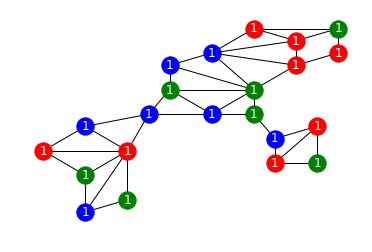

2.71428571429 3
3.35714285714 3
3.35714285714 3
4.0 4
4.03571428571 5
2.92857142857 3
3.5 3
3.64285714286 3
3.46428571429 3
3.42857142857 4
3.25 3
3.32142857143 4
2.5 2
2.82142857143 3
3.96428571429 4
4.0 5
3.5 4
4.25 5
3.28571428571 4
3.35714285714 4
4.28571428571 5
3.46428571429 3
3.5 3
3.53571428571 4
3.32142857143 3
3.17857142857 3
3.53571428571 4
3.39285714286 3
3.42857142857 3
4.25 5
2.96428571429 3
2.75 3
3.92857142857 4
3.71428571429 4
3.92857142857 4
3.17857142857 3
2.82142857143 3
3.42857142857 4
2.64285714286 2
2.53571428571 3
3.25 3
3.21428571429 3
2.21428571429 2
3.53571428571 4
3.28571428571 4
2.89285714286 3
3.28571428571 3
3.32142857143 4
2.71428571429 3
3.14285714286 3


In [17]:
game = risk(0)

print(game.players[0].owned_territories)
print(game.players[1].owned_territories)
print(game.players[2].owned_territories)
print(get_continent_ownership(game.players[0], game.board))
game.print_board()

num_iters = 50
mean_spreads = []
median_spreads = []
for i in range(num_iters):
    game.reset_game()
    mea_spread, med_spread = average_territory_distance(game.players[0], game.board)
    mean_spreads.append(mea_spread)
    median_spreads.append(med_spread)
    
#     print(mea_spread, med_spread)
#     game.print_board()    
    
# print(mean_spreads)
# print(median_spreads)
for i in range(num_iters):
    print(mean_spreads[i], median_spreads[i])

Because the median is always an integer and the board is small, the median tends to be limited to the values 2, 3, 4 and 5. This may remove some information contained in the mean spread. However, since there is not a perfet correlation between the two, I will use both.

<h3>F2: Strength of front line territories</h3>

Notes:
- Strength is determined by number of units on that territory
- Front line territories are defined as the ones directly adjacent to territories owned by other players
- Relative strength of a territory, t, is calculated as number of units on t / number of units on adjacent enemy territories.
    - Relative strength of a player is the average strength of all owned territories.
    - Increased number of border territories decreases strength.
    - Increased number of units on adjacent enemy territories decreases strength.
    - Increased units on a border territory increases strength.

Learning notes:
- The distinction between front line and others will probably be more useful in the late game
    - It will be slow to calculate in early game but can be used then as an approximate metric for overall unit numbers
    
_Implementation notes:_
- _What is preferable, total units on front line or average? Both will be calculated and total will be returned for now_
- _I am also returning the minimum number of front-line units since that may also be useful._
    - _As an extension to this, I'm returning which territory has the lowest number of units._

In [ ]:
## F2 ##
def strength_of_front_line(player, world_map):
    """Calculate the number of players in each territory adjacent to enemy territory"""
    N = len(player.owned_territories)
    min_front_line_units = np.inf
    front_line_units = []
    num_border_territories = 0
    border_strengths = []
    
    # Loop through all player territory to determine whether it is in the front line
    for t in range(N): #territories
        t_index = player.owned_territories[t]
        
        is_front_line = False
        for at in world_map.territory_connections[t_index]: #adjacent territories
            if at not in player.owned_territories:
                num_border_territories += 1
                is_front_line = True
                break
        
        if is_front_line:
            t_num_units = world_map.territories[t_index].num_units
            front_line_units.append(t_num_units)
            
            if t_num_units < min_front_line_units:
                # Determine whether the current territory is the weakest territory
                #     on this player's border
                min_front_line_units = t_num_units
                weakest_link = t_index
            
            # Calculate relative strength
            enemy_strength = 0
            for at in world_map.territory_connections[t_index]:
                if at not in player.owned_territories:
                    enemy_strength += world_map.territories[at].num_units
            border_strengths.append(world_map.territories[t_index].num_units / enemy_strength)
    border_strength = np.array(border_strengths).sum() / num_border_territories
    
    if min_front_line_units == np.inf:
        raise "This function has found no front line territories."
    
    tot_front_line_units = np.sum(front_line_units)
    mean_front_line_units = np.mean(front_line_units)
    
    return border_strength, tot_front_line_units, min_front_line_units, weakest_link

<h3>F3: Continent ownership</h3>

In [ ]:
## F3 ##
def get_continent_ownership(player, world_map):
    """Determine the portion of each continent owned by the player"""
    continent_portions = np.zeros(3)
    
    for t_index in player.owned_territories:
        # Determine continent
        if t_index <= 11:
            # Territory is in Asia
            continent_portions[0] += 1
        elif t_index <= 17:
            # Territory is in Africa
            continent_portions[1] += 1
        elif t_index <= 21:
            # Territory is in Australasia
            continent_portions[2] += 1
            
    continent_portions = continent_portions / np.array([12, 6, 4])
    
    return continent_portions

Testing border strength

In [ ]:
game = risk(0)

game.initial_reinforcements()

game.print_board(True)

print(strength_of_front_line(game.players[0], game.board))

In [ ]:
print(np.log(0.50952380952380949))
print(np.log(0.41666666666666663))

<h2>Running games with 3 random players</h2>

In [ ]:
game = risk(0)

print(game.players[0].owned_territories)
print(game.players[1].owned_territories)
print(game.players[2].owned_territories)
print(get_continent_ownership(game.players[0], game.board))
game.print_board()

In [ ]:
game = risk(0)

game.initial_reinforcements()

game.print_board()

np.random.seed(45)

rounds = 0

while rounds < 20:
    
    for i in [0,1,2]:

        print('Player', i ,'begins Turn')

        game.reinforce(i)

        game.print_board()

        game.attack(i)

        game.print_board()
        
    rounds += 1

In [ ]:
vars(game.players[0])